# Eager Execution: Working with Gradients

This notebook demonstrates:

* How to get gradients using TensorFlow's eager execution capabilities
* How to apply the gradients so you can update your variables

# Setup: Import eager and enable eager execution.


In [0]:
# Import TensorFlow.
import tensorflow as tf


# Enable eager execution.
tf.enable_eager_execution()

# Fitting a Simple Linear Model

## Step 1: Synthesize some data

To demonstrate fitting a model with TensorFlow's eager execution, we'll fit a linear model to some synthesized data (which includes some noise).

In the code, we  use the variable names `w` and `b` to represent the single weight and bias we'll use to fit our model.

In [0]:
# The constants we'll try to fit our variables to:
true_w = 3
true_b = 2

NUM_EXAMPLES = 1000

# Our inputs:
inputs = tf.random_normal(shape=[NUM_EXAMPLES, 1])

# Our labels, with noise:
noise = tf.random_normal(shape=[NUM_EXAMPLES, 1])
labels = inputs * true_w + true_b + noise

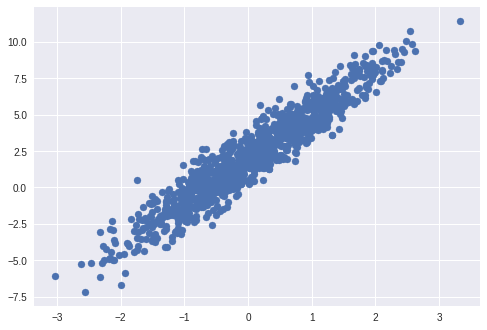

In [0]:
# Plot the Data (Optional)

import matplotlib.pyplot as plt

plt.scatter(inputs, labels)
plt.show()

## Step 2: Define our TensorFlow variables

We'll use Keras's object-oriented [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer to create our variables. In this case, we'll create a `Dense` layer with a single weight and bias.

In [0]:
# Create TensorFlow Variables using Keras's Dense layer.

wb = tf.keras.layers.Dense(units=1, use_bias=True)

# We can access the underlying TensorFlow variables using wb.variables.
# However, the variables won't exist until the dimensions of the input
# tensors are known. Once the dimensions of the input tensors are known,
# Keras can create and initialize the variables. Until then, Keras will
# report the variables as an empty list: [].

wb.variables

[]

## Step 3: *Define the loss function*

Our loss function is the standard L2 loss (where we reduce the loss to its mean across its inputs).

In [0]:
def loss_fn(predictions, labels):
  """Calculates the mean L2 loss for our linear model."""
  return tf.reduce_mean(tf.square(predictions - labels))

In [0]:
# Test loss function (optional).

loss_fn(wb(inputs), labels)

<tf.Tensor: id=1252, shape=(), dtype=float32, numpy=16.979801>

In [0]:
# At this point, the variables exist, and can now be queried:

w, b = wb.variables
print("w: %f" % w.numpy())
print("b: %f" % b.numpy())

w: -0.311619
b: 0.000000


## Step 4: Create an optimizer

We'll use a `GradientDescentOptimizer` to fit our model.

In [0]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)

### Step 5: Define a training step

To fit model variables to the data we'll need to:

1. Calculate the gradients of the loss with respect to the model variables.
2. Use `optimizer` to compute updates to the variable values based on those gradients.

To calculate the gradients, we use the [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) context manager
and its `gradient` function to compute gradients through computation conducted within its context:


In [0]:
def run_step(inputs, labels):
  with tf.GradientTape() as g:
    loss = loss_fn(wb(inputs), labels)
  # Compute the partial derivatives of loss with respect to the variables
  grads = g.gradient(loss, wb.variables)
  optimizer.apply_gradients(zip(grads, wb.variables))
  return loss

Repeatedly running the training step will nudge the variables towards the values that best fit the data (i.e., "w" will move closer to 3.0, while "b" will tend to 2.0):



In [0]:
w, b = wb.variables
print("Values of w, b BEFORE applying gradients: %f, %f" % (w.numpy(), b.numpy()))
run_step(inputs, labels)
print("Values of w, b AFTER  applying gradients: %f, %f" % (w.numpy(), b.numpy()))


Values of w, b BEFORE applying gradients: 2.725763, 1.894334
Values of w, b AFTER  applying gradients: 2.774932, 1.922555


## Step 6: Create a training loop

Of course, now we can simply turn all of this code into a self-standing training loop. We'll also capture our loss and approximations of `w` and `b` and plot them over time.

[0.9409681558609009, 1.3733772039413452, 1.7128530740737915, 1.9793939590454102, 2.188689708709717, 2.3530514240264893, 2.4821391105651855, 2.583533763885498, 2.6631851196289062, 2.7257626056671143]


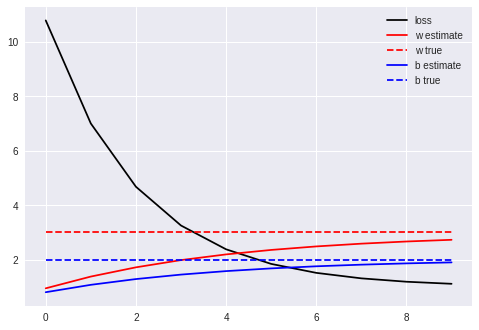

In [0]:
# Train our variables.

# numpy is used for its asscalar() function.
import numpy as np

num_training_steps = 10

def train_model(inputs, labels, wb, optimizer, num_training_steps):
  loss_at_step = []
  w_at_step = []
  b_at_step = []
  for step_num in range(num_training_steps):
    loss_at_step.append(run_step(inputs, labels))
    w, b = wb.variables
    w_at_step.append(np.asscalar(w.numpy()))
    b_at_step.append(np.asscalar(b.numpy()))

  print(w_at_step)
  t = range(0, num_training_steps)
  plt.plot(t, loss_at_step, 'k',
           t, w_at_step, 'r',
           t, [true_w] * num_training_steps, 'r--',
           t, b_at_step, 'b',
           t, [true_b] * num_training_steps, 'b--')
  plt.legend(['loss', 'w estimate', 'w true', 'b estimate', 'b true'])
  plt.show()

train_model(inputs, labels, wb, optimizer, num_training_steps)